In [172]:
import numpy as np
from meegkit.trca import TRCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from preprocessing import BCIDataProcessor

In [173]:
recording_path = '../recordings/recording_ssvep2.raw.fif'
window_size = 2
window_overlap = 0
processor = BCIDataProcessor(recording_path, l_freq=1, h_freq=None, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process()

In [174]:
def process_for_trca(data):
    """
    Process the data for TRCA analysis.
    """
    # Step 1: Gather all trials into a list
    all_trials = []
    all_labels = []

    # Map frequencies to label numbers
    freqs = sorted(map(float, data.keys()))  # sorted list of frequencies
    freq_to_label = {freq: idx for idx, freq in enumerate(freqs)}

    for freq_str, eeg_trials in data.items():
        freq = float(freq_str)
        label = freq_to_label[freq]  # integer label for this frequency

        all_trials.append(eeg_trials)  # shape (n_trials, n_channels, n_samples)
        all_labels.extend([label] * eeg_trials.shape[0])

    # Step 2: Stack all trials
    # Now shape will be (total_trials, n_channels, n_samples)
    all_trials = np.vstack(all_trials)
    all_labels = np.array(all_labels)

    # Step 3: Rearrange axes to (samples, channels, trials)
    # First: (total_trials, channels, samples) -> (samples, channels, total_trials)
    X, y = all_trials, all_labels
    return X, y

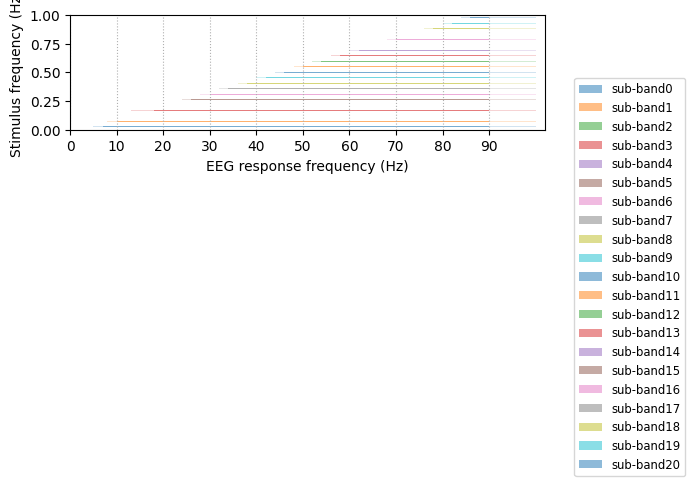

In [175]:
filterbank = [
    [(7, 90), (5, 100)],
    [(10, 90), (8, 100)],
    [(14, 90), (12, 100)],
    # [(18, 90), (13, 100)],
    # [(22, 90), (19, 100)],
    # [(26, 90), (24, 100)],
    # [(30, 90), (28, 100)],
    # [(34, 90), (32, 100)],
    # [(38, 90), (36, 100)],
    # [(42, 90), (40, 100)],
    # [(46, 90), (44, 100)],
    # [(50, 90), (48, 100)],
    # [(54, 90), (52, 100)],
    # [(58, 90), (56, 100)],
    # [(62, 90), (60, 100)],
    # [(66, 90), (64, 100)],
    # [(70, 90), (68, 100)],
    # [(74, 90), (72, 100)],
    # [(78, 90), (76, 100)],
    # [(82, 90), (80, 100)],
]

f, ax = plt.subplots(1, figsize=(7, 4))
for i, _band in enumerate(filterbank):
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][1][0], xmax=filterbank[i][1][1],
               alpha=0.2, facecolor=f"C{i}")
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][0][0], xmax=filterbank[i][0][1],
               alpha=0.5, label=f"sub-band{i}", facecolor=f"C{i}")


ax.set_ylabel("Stimulus frequency (Hz)")
ax.set_xlabel("EEG response frequency (Hz)")
ax.set_xlim([0, 102])
ax.set_xticks(np.arange(0, 100, 10))
ax.grid(True, ls=":", axis="x")
ax.legend(bbox_to_anchor=(1.05, .5), fontsize="small")
plt.tight_layout()
plt.show()

In [176]:
from sklearn.model_selection import train_test_split

X, y = process_for_trca(data)

# Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transpose data after splitting
X_train, X_test = np.transpose(X_train, (2, 1, 0)), np.transpose(X_test, (2, 1, 0))

trca = TRCA(sfreq=250, filterbank=filterbank, ensemble=True, estimator='lwf', method='riemann')
trca.fit(X_train, y_train)
y_pred = trca.predict(X_test)

accuracy = np.mean(y_test == y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 55.56%


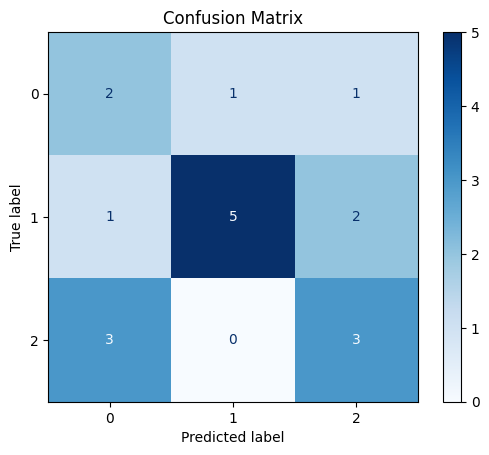

In [177]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()